In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from src.molecular_hamiltonian import Molecular_Hamiltonian
from src.bf_quantum_state import BFQuantumState
import src.constants

First we compute the ground states and ground state energies and store them for later use.

In [2]:
molecules = ['H2', 'LiH', 'H2O', 'NH3']
for molecule in molecules:
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    energy_eig_vals, eigvecs = Molecular_Hamiltonian(molecule).diagonalize(1, True)
    ground_state = pt.tensor(eigvecs[:, 0])
    np.save(save_direc_eigs, energy_eig_vals)
    np.save(save_direc_groundstate, ground_state)

Now we do shadow measurements on our ground state and store them to later predict the energy.

In [40]:
molecules = ['H2', 'LiH']
num_of_measurements = 300000
measurement_methods = np.array(['derandomized', 'randomized'])
for molecule in molecules:
    print('starting molecule ' + molecule)
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    ground_state = pt.tensor(np.load(save_direc_groundstate, allow_pickle=True), dtype=src.constants.DEFAULT_COMPLEX_TYPE)
    for l in range(0, 2):
        observables = Molecular_Hamiltonian(molecule).observables_for_energy_estimation()
        measurement_procedure, measurement_index = BFQuantumState(Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner(),
                            ground_state).measurement_shadow(num_of_measurements, measurement_methods[l], observables)
        save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        np.save(save_direc_procedure, measurement_procedure)
        np.save(save_direc_index, measurement_index)

starting molecule H2
25
starting molecule LiH
786


In [5]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [23]:
measurement_methods = np.array(['derandomized', 'randomized'])
num_of_measurements = 500
molecules = ['H2', 'LiH', 'H2O', 'NH3']
energies_shadow = []
energies_brute = []
for molecule in molecules:
    for l in range(0,2):
        save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:num_of_measurements,:],
                                                                  measurement_index[0:num_of_measurements], Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
        energy_shadow = Molecular_Hamiltonian(molecule).energy_shadow(measurements).real()
        save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
        energy_brute = np.load(save_direc_eigs, allow_pickle=True)
        energies_shadow.append(energy_shadow)
        energies_brute.append(energy_brute)
        print('exact energie of molecule ' + molecule + ' = ' + str(energy_brute))
        print('energie estimated with ' + measurement_methods[l] + ' shadows of molecule' + molecule + ' = ' + str(energy_shadow))

exact energie of molecule H2 = [-1.10115033]
energie estimated with derandomized shadows of moleculeH2 = (-1.090212863619266+0j)
exact energie of molecule H2 = [-1.10115033]
energie estimated with randomized shadows of moleculeH2 = (-1.1815242672701383+0j)


Now we plot the relative error in the prediction of the energy $\frac{|E_{exact} - E_{shadow}|}{E_{exact}}$ against the number of measurements.

In [15]:
measurement_methods = np.array(['derandomized', 'randomized'])
numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000])
batches = 15
molecules = ['H2', 'LiH']
all_rel_errors = {}
for molecule in molecules:
    all_rel_errors[molecule] = {}
    for l in range(0,2):
        rel_errors_in_one_batch = np.zeros((np.size(numbers_of_measurements), batches))
        for b in range(0, batches):
            save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
            energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
            for n in range(0, np.size(numbers_of_measurements)):
                save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
                save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
                measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
                measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[b*numbers_of_measurements[n]:(b+1)*numbers_of_measurements[n],:],
                                                                          measurement_index[b*numbers_of_measurements[n]:(b+1)*numbers_of_measurements[n]], Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
                energy_shadow = float(Molecular_Hamiltonian(molecule).energy_shadow(measurements).real)
                rel_errors_in_one_batch[n,b] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)
        all_rel_errors[molecule][measurement_methods[l]] = rel_errors_in_one_batch
save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
np.save(save_direc_rel_errors, all_rel_errors)

[0.02450968 0.02977141 0.01155717 0.00377381 0.00446999 0.00359729
 0.00235882 0.00145879] derandomized
[0.04010157 0.02597011 0.01369543 0.00848384 0.00690705 0.00332537
 0.00327402 0.0023251 ]
[0.03217488 0.02160683 0.02260123 0.01305183 0.00993349 0.00563032
 0.00405019 0.00306284] randomized
[0.04359265 0.03188355 0.02934958 0.01848677 0.01366311 0.00665756
 0.00606272 0.00449311]
[0.01959641 0.02234476 0.0188041  0.00349979 0.00284809 0.00176031
 0.00135553 0.00082556] derandomized
[0.0314315  0.02950102 0.01337825 0.00460877 0.00487343 0.00494899
 0.00514037 0.00503568]
[0.0058733  0.00561211 0.00625472 0.00673139 0.00472889 0.00418171
 0.00335644 0.00440686] randomized
[0.00994176 0.00809253 0.00891293 0.00691587 0.00610575 0.00549039
 0.00546486 0.00612434]


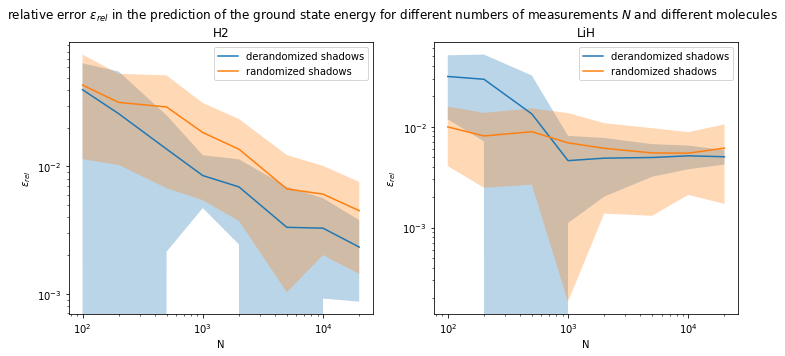

In [16]:
measurement_methods = np.array(['derandomized', 'randomized'])
numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000])
molecules = ['H2', 'LiH']
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('relative error $\epsilon_{rel}$ in the prediction of the ground state energy for different numbers of measurements $N$ and different molecules')
save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
all_rel_errors_dict = np.load(save_direc_rel_errors, allow_pickle=True)
all_rel_errors_dict = all_rel_errors_dict.item()
for molecule in molecules:
    for l in range(0,2):
        rel_errors = all_rel_errors_dict[molecule][measurement_methods[l]]
        rel_errors_mean = np.mean(rel_errors, axis = 1)
        rel_errors_std = np.std(rel_errors, axis = 1)
        print(rel_errors_std, measurement_methods[l])
        print(rel_errors_mean)
        if molecule == 'H2':
            i = 0
            j = 0
        if molecule == 'LiH':
            i = 0
            j = 1
        if molecule == 'H2O':
            i = 1
            j = 0
        if molecule == 'NH3':
            i = 1
            j = 1
        axs[j].errorbar(numbers_of_measurements, rel_errors_mean, label = measurement_methods[l] + ' shadows')
        axs[j].fill_between(numbers_of_measurements, rel_errors_mean - rel_errors_std, rel_errors_mean + rel_errors_std, alpha = 0.3)
        axs[j].set(xscale = 'log', xlabel = 'N', ylabel = '$\epsilon_{rel}$', yscale = 'log')
        axs[j].set_title(molecule)
        axs[j].legend()

Now we estimate the energy using direct measurements. Later on we will compare the two approaches.

In [19]:
def conversion_to_measurement_outcome_shape(measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    return measurement_array

In [40]:
molecules = ['H2']
numbers_of_measurements_for_each_observable = np.array([10, 20, 50, 100, 150, 200, 500, 700, 1000])
batches = 50
for molecule in molecules:
    observables_array_shape, coefficients = Molecular_Hamiltonian(molecule).observables_and_coefficients_for_energy_estimation()
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    ground_state = pt.tensor(np.load(save_direc_groundstate, allow_pickle=True), dtype=src.constants.DEFAULT_COMPLEX_TYPE)
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
    errors = np.zeros((batches, np.size(numbers_of_measurements_for_each_observable)))
    for k in range(0, batches):
        for j in range(0, np.size(numbers_of_measurements_for_each_observable)):
            errors_all_observables= np.array([])
            energy = 0
            for o in range(0, np.size(observables_array_shape)):
                observable_dict_shape = {}
                if not observables_array_shape[o]:
                    energy = energy + coefficients[o]
                    continue
                for pauli_observable in observables_array_shape[o]:
                    observable_dict_shape[pauli_observable[1]] = str(pauli_observable[0])
                measurement_index, prob = BFQuantumState(Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner(), ground_state).measure_pauli(observable_dict_shape, numbers_of_measurements_for_each_observable[j])
                measurement_arrays = conversion_to_measurement_outcome_shape(measurement_index, Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
                measurement_outcome = 0
                for i in range(0, int(prob.size(dim=0))):
                    measurement_outcome_one_meas = 1
                    for pauli_observable in observables_array_shape[o]:
                        measurement_outcome_one_meas = measurement_outcome_one_meas * measurement_arrays[i][pauli_observable[1]]
                    measurement_outcome = measurement_outcome + prob[i] * measurement_outcome_one_meas
# until here we just obtained the measurement outcome of an arbitrary pauli observable array, now we estimate the energy from this
                energy = energy + coefficients[o] * measurement_outcome
            errors[k,j] = np.abs(energy_brute - energy) / np.abs(energy_brute)

C:\Users\Lenna\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


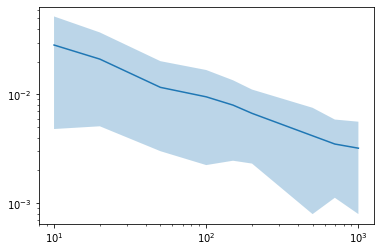

In [43]:
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis = 0)
plt.yscale('log')
plt.xscale('log')
plt.plot(numbers_of_measurements_for_each_observable, error_mean)cd 
plt.fill_between(numbers_of_measurements_for_each_observable, error_mean - error_std, error_mean + error_std, alpha = 0.3)

In [42]:
print(error_mean)

[0.02847431 0.02113048 0.01162136 0.00951166 0.00798146 0.00670424
 0.00416789 0.00350168 0.00320658]
